In [1]:
import pandas as pd
import pathlib
import json
from loguru import logger

import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from src.dataset import DatasetLoader
from src.dataset import Dataset
from src.pipeline import Pipeline
from src.tuning import objective
from src.formal_concept import FormalConcept

import warnings

warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
warnings.filterwarnings("ignore", message="is_sparse is deprecated")

In [2]:
dataset = Dataset.water
n_trials = 20
METRIC = accuracy_score
NUM_FOLDS = 5
STATE = 101

In [3]:
data_loader = DatasetLoader(pathlib.Path("./datasets"))

data = data_loader.load_dataset(dataset)
data, target = data.drop(columns=["target"]), data[["target"]]

data.head(3)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,0.000,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,0.650,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,0.003,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01


# 0. Fit models

In [4]:
model_params = {
    "FormalConcept": {},
    "CatBoost": {"silent": True},
    "XGBoost": {"enable_categorical": True},
    "KNN": {},
    "RandomForest": {},
    "LogRegression": {"max_iter": 10000},
    "DecisionTree": {},
}

for model_name, params in model_params.items():
    logger.info(f"Model {model_name}")

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        study_name="Choose models",
    )
    logger.info("Start hyperparams optimization")
    study.optimize(
        lambda trial: objective(trial, data, target, model_name),
        catch=(Exception,),
        gc_after_trial=True,
        n_trials=n_trials,
    )
    params.update(study.best_params)
    
    with open(f"checkpoints/{model_name}_best_params_{dataset.name}.json", 'w') as output_file:
        params_str = json.dumps(params, indent=2)
        output_file.write(params_str)

2023-12-11 16:53:39.667 | INFO     | __main__:<module>:12 - Model FormalConcept
[I 2023-12-11 16:53:39,671] A new study created in memory with name: Choose models
2023-12-11 16:53:39.673 | INFO     | __main__:<module>:19 - Start hyperparams optimization
2023-12-11 16:53:39.690 | INFO     | src.tuning.choose_model:_choose_formal_concept:111 - ['nitrites', 'bacteria', 'aluminium', 'cadmium', 'flouride', 'arsenic']
2023-12-11 16:53:39.693 | INFO     | src.tuning.objective:objective:21 - Selected config: {'aluminium': 0.3836210499962905, 'ammonia': 1.9744511566481662, 'arsenic': 0.6657512514585138, 'barium': 0.06328720981062032, 'cadmium': 0.07036106940768139, 'chloramine': 6.4712198123553195, 'chromium': 0.6733396348666738, 'copper': 1.2259629514109947, 'flouride': 0.36709549550725723, 'bacteria': 0.7260418269209932, 'viruses': 0.2988232584366124, 'lead': 0.16614938141170627, 'nitrates': 7.056698878543787, 'nitrites': 1.241117037120339, 'mercury': 0.004107936225251919, 'perchlorate': 58.3

In [5]:
fold_generator = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=STATE)

feature_names = [data.columns[feature_idx] for _key, feature_idx in model_params["FormalConcept"].items() if _key.startswith("feature")]

models_dct = {
    "CatBoost": CatBoostClassifier(**model_params["CatBoost"]),
    "XGBoost": XGBClassifier(**model_params["XGBoost"]),
    "MostFrequent": DummyClassifier(strategy="most_frequent"),
    "KNN": KNeighborsClassifier(**model_params["KNN"]),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(**model_params["RandomForest"]),
    "LogRegression": LogisticRegression(**model_params["LogRegression"]),
    "DecisionTree": DecisionTreeClassifier(**model_params["DecisionTree"]),
    "FormalConcept": FormalConcept(thr_dict=model_params["FormalConcept"], n_concepts=model_params["FormalConcept"]["n_concepts"], features=feature_names),
}

In [6]:
summary_list = []
formal_concept_pipelines = []

for model_name, model in models_dct.items():
    logger.info(f"Model: {model_name}")
    pipeline = Pipeline(base_model=model)

    folds = fold_generator.split(data, y=target)
    for i, (train_fold_idx, test_fold_idx) in enumerate(folds):
        # logger.info(f"Fold: {i + 1} / {NUM_FOLDS}")

        train_data, train_target = data.iloc[train_fold_idx], target.iloc[train_fold_idx]
        test_data, test_target = data.iloc[test_fold_idx], target.iloc[test_fold_idx]
        
        pipeline.fit(train_data, train_target)
        predictions = pipeline.predict(test_data)

        metric_value = METRIC(test_target, predictions)

        result_dict = {
            "fold": i,
            "model": model_name,
            "metric_value": metric_value
        }
        summary_list.append(result_dict)

        if model_name == "FormalConcept":
            formal_concept_pipelines.append(pipeline)

summary = pd.DataFrame.from_records(summary_list)
summary.columns = ["fold", "model", "Accuracy"]

summary = pd.pivot_table(summary, values="Accuracy", index="fold", columns="model")

summary.to_csv(f"checkpoints/{model_name}_metrics_{dataset.name}.csv")

summary

2023-12-11 16:58:35.486 | INFO     | __main__:<module>:5 - Model: CatBoost
2023-12-11 16:58:52.508 | INFO     | __main__:<module>:5 - Model: XGBoost
2023-12-11 16:58:53.247 | INFO     | __main__:<module>:5 - Model: MostFrequent
2023-12-11 16:58:53.553 | INFO     | __main__:<module>:5 - Model: KNN
2023-12-11 16:58:53.941 | INFO     | __main__:<module>:5 - Model: NaiveBayes
2023-12-11 16:58:54.264 | INFO     | __main__:<module>:5 - Model: RandomForest
2023-12-11 16:59:15.998 | INFO     | __main__:<module>:5 - Model: LogRegression
2023-12-11 16:59:16.514 | INFO     | __main__:<module>:5 - Model: DecisionTree
2023-12-11 16:59:16.978 | INFO     | __main__:<module>:5 - Model: FormalConcept


model,CatBoost,DecisionTree,FormalConcept,KNN,LogRegression,MostFrequent,NaiveBayes,RandomForest,XGBoost
fold,,,,,,,,,
0,0.948125,0.915000,0.881875,0.886875,0.895000,0.881875,0.833125,0.943750,0.881875
1,0.939962,0.911194,0.118824,0.899312,0.903064,0.881176,0.860538,0.938086,0.881176
2,0.963727,0.926204,0.108818,0.914947,0.915572,0.891182,0.834271,0.955597,0.891182
3,0.952470,0.920575,0.888055,0.904315,0.911194,0.888055,0.864290,0.948718,0.888055
4,0.948718,0.921826,0.112570,0.902439,0.903064,0.887430,0.838024,0.944340,0.887430


# 1. Visualizations

In [7]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

import neural_fca_example.neural_lib as nl

In [8]:
cn = formal_concept_pipelines[0].base_model.cn

vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

vis.init_mover_per_poset(cn.poset)
mvr = vis.mover

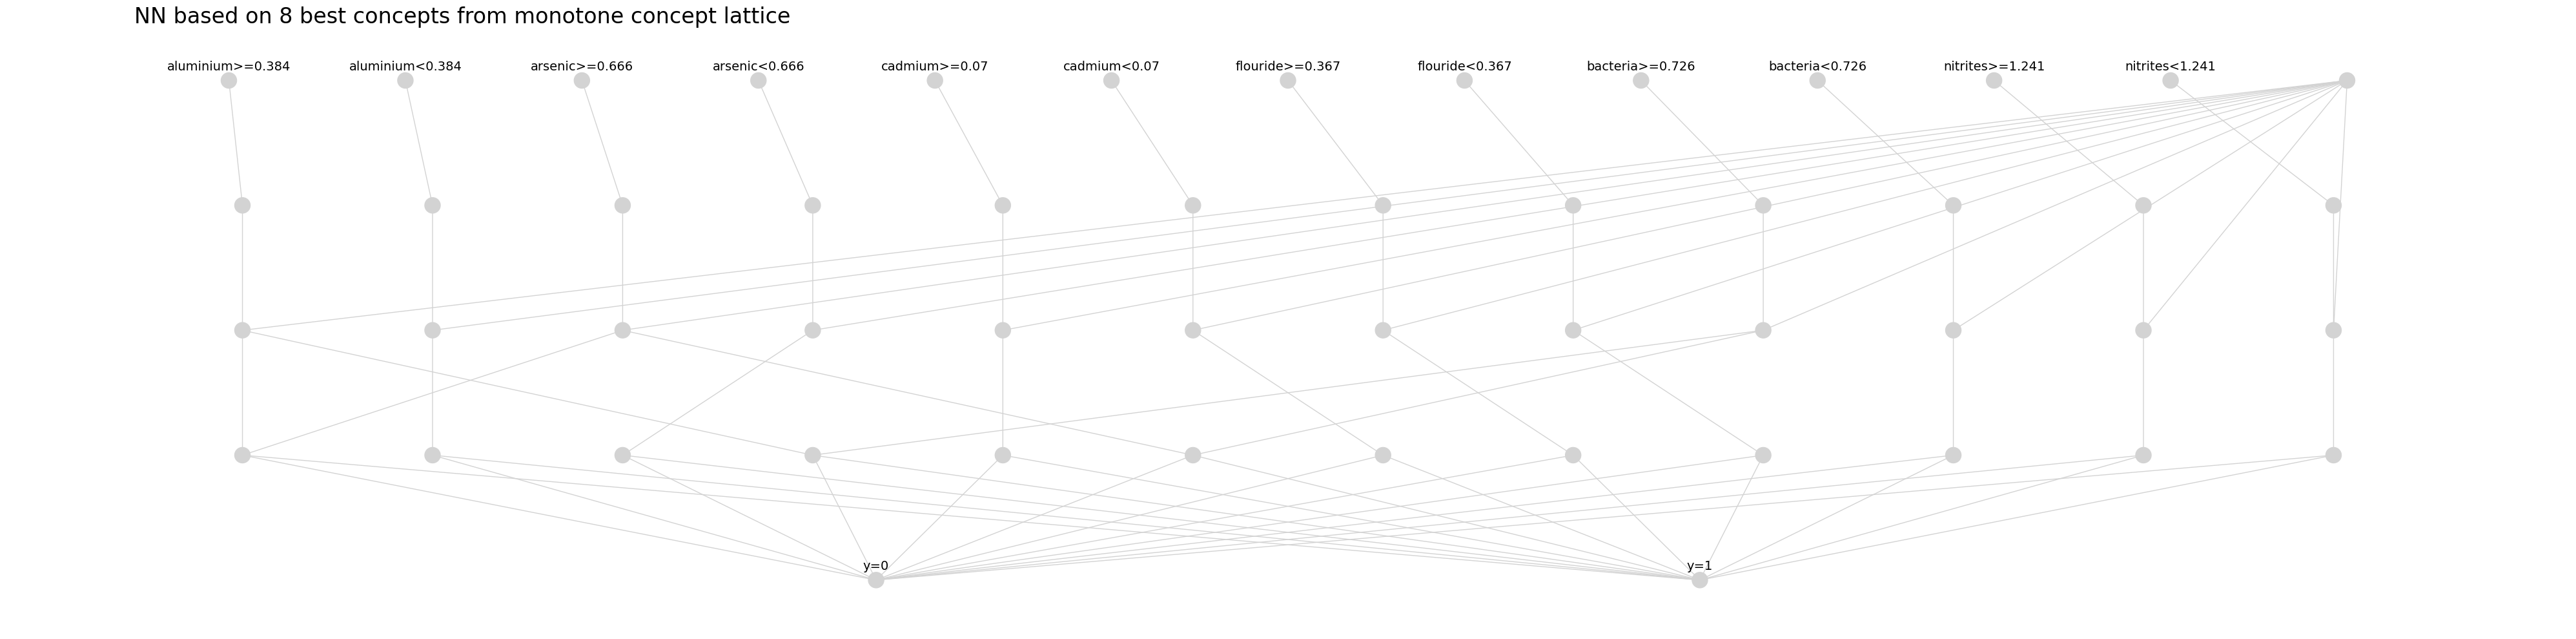

In [9]:
fig, ax = plt.subplots(figsize=(40,10))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color='lightgray'
)
plt.title(f'NN based on {formal_concept_pipelines[0].base_model.n_concepts} best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

/home/aseliverstov/.cache/pypoetry/virtualenvs/osda-bhw-kYdWE48u-py3.10/lib/python3.10/site-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


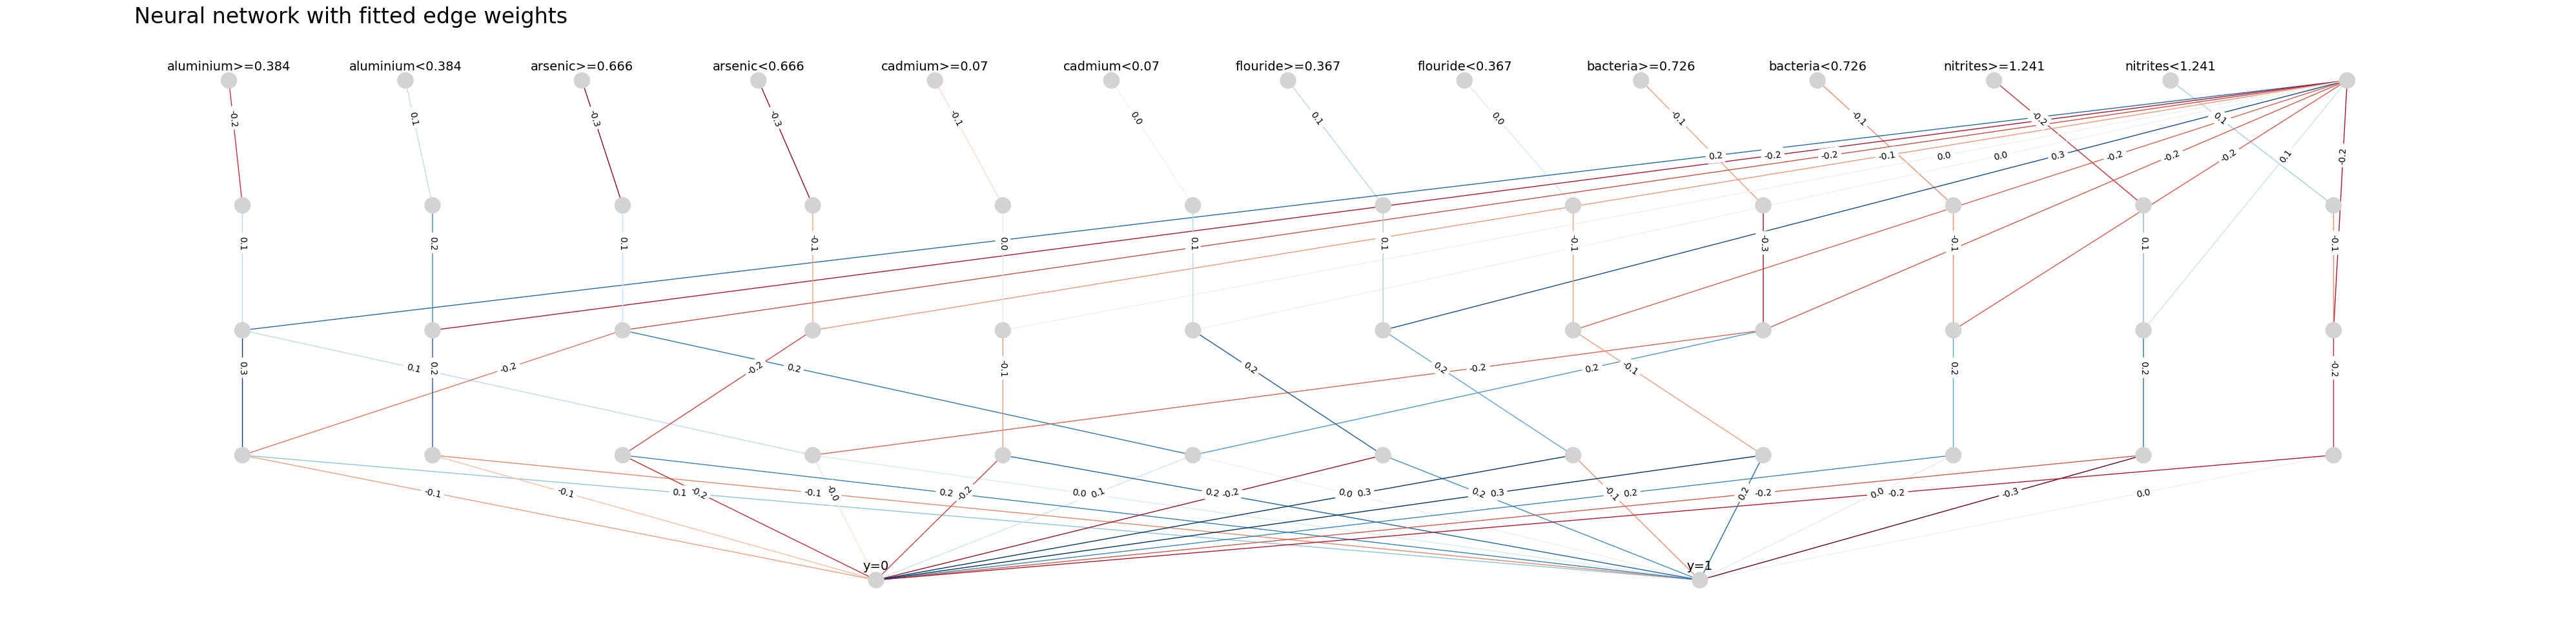

In [10]:
edge_weights = cn.edge_weights_from_network()

import networkx as nx

fig, ax = plt.subplots(figsize=(40,10))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig(f'images/fitted_network_{dataset.name}.png')
plt.show()